# Predicting Remaining Useful Life (RUL) of Turbofan Engines
## NASA C-MAPSS FD001 — Classical Machine Learning (CPU-only)

## Dataset Overview

The NASA C-MAPSS dataset is a benchmark dataset for predictive maintenance.
Each engine represents a full operational lifecycle recorded as a multivariate time-series.

FD001 is used because it contains a single operating condition and a single fault mode,
making it suitable for classical ML on CPU.

Sensor semantic meanings are not provided. Sensor values must be treated as abstract signals.
The dataset is simulated but industry-accepted.

## Project Objectives

- Predict Remaining Useful Life (RUL) as a regression problem
- Build a leakage-safe, reproducible ML pipeline
- Ensure CPU-only feasibility
- Produce interpretable and trustworthy predictions

Non-objectives include deep learning, cross-dataset generalization, and deployment.

## Environment Setup

Reproducibility ensures that results can be audited and repeated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import joblib
import sys

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Python version:', sys.version)

Python version: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


## Data Understanding 

- One row corresponds to one engine at one operating cycle
- engine_id identifies engines
- cycle is a time index
- Operational settings and sensors have unknown semantics

Training data runs until failure. Test data is truncated. RUL is not directly provided.

In [2]:
columns = (
    ['engine_id', 'cycle'] +
    [f'op_setting_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)

train_raw = pd.read_csv('train_FD001.txt', sep=r'\s+', header=None)
test_raw = pd.read_csv('test_FD001.txt', sep=r'\s+', header=None)
rul_test = pd.read_csv('RUL_FD001.txt', header=None, names=['RUL'])

train_raw.columns = columns
test_raw.columns = columns

train_raw.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Loading & Validation

Validation ensures structural correctness before modeling.

In [3]:
assert train_raw.isnull().sum().sum() == 0
assert train_raw.duplicated().sum() == 0
assert train_raw.groupby('engine_id')['cycle'].is_monotonic_increasing.all()

print('Training shape:', train_raw.shape)
print('Engines:', train_raw['engine_id'].nunique())

Training shape: (20631, 26)
Engines: 100


## Target Construction (RUL Engineering)

RUL is defined as the remaining cycles until failure and is capped to reduce noise.

In [4]:
train = train_raw.copy()

max_cycle = train.groupby('engine_id')['cycle'].max().reset_index()
max_cycle.columns = ['engine_id', 'max_cycle']

train = train.merge(max_cycle, on='engine_id')
train['RUL'] = train['max_cycle'] - train['cycle']

RUL_CAP = 125
train['RUL'] = train['RUL'].clip(upper=RUL_CAP)

train.drop(columns='max_cycle', inplace=True)
assert train['RUL'].min() >= 0

## Data Preprocessing

Remove non-informative sensors conservatively.

In [5]:
sensor_cols = [c for c in train.columns if 'sensor_' in c]

low_var = train[sensor_cols].var()
drop_sensors = low_var[low_var < 1e-5].index.tolist()

train.drop(columns=drop_sensors, inplace=True)
test = test_raw.drop(columns=drop_sensors)

print('Removed sensors:', drop_sensors)

Removed sensors: ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


In [9]:
# Recompute sensor columns after removal
sensor_cols = [c for c in train.columns if 'sensor_' in c]


## Exploratory Data Analysis (EDA)

EDA is used to visually understand degradation behavior **without assuming sensor meaning**.

### EDA Questions
- How long do engines typically operate before failure?
- How does Remaining Useful Life (RUL) evolve over cycles?
- How variable are sensors relative to each other?
- Are sensors strongly correlated?

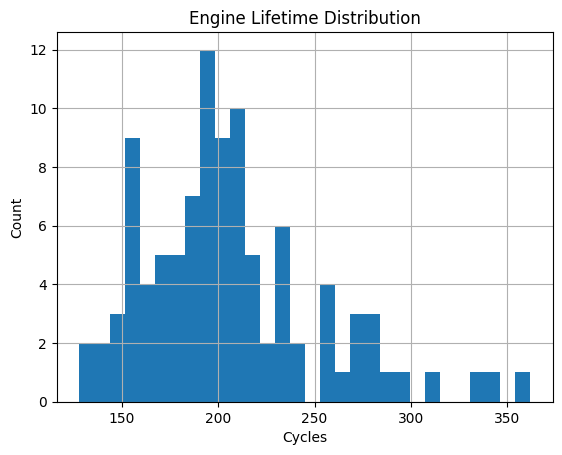

In [10]:
# Engine lifetime distribution
plt.figure()
train.groupby('engine_id')['cycle'].max().hist(bins=30)
plt.xlabel('Cycles')
plt.ylabel('Count')
plt.title('Engine Lifetime Distribution')
plt.show()

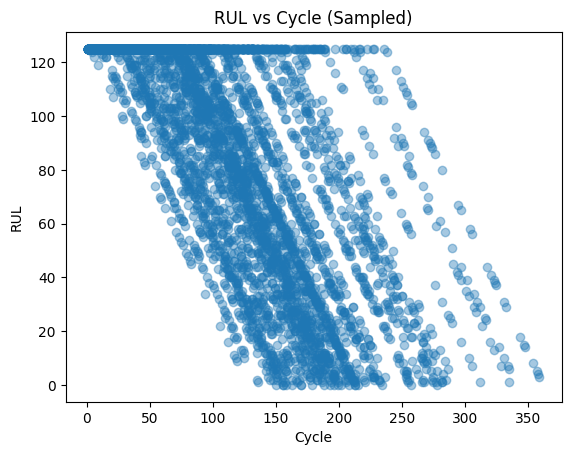

In [11]:
# RUL vs cycle (sampled for clarity)
sample_df = train.sample(5000, random_state=RANDOM_STATE)
plt.figure()
plt.scatter(sample_df['cycle'], sample_df['RUL'], alpha=0.4)
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title('RUL vs Cycle (Sampled)')
plt.show()

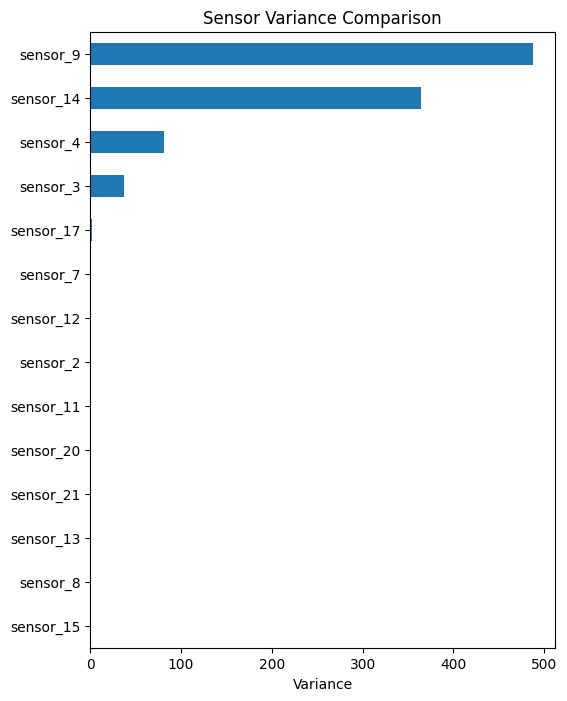

In [12]:
# Sensor variance comparison
train[sensor_cols].var().sort_values().plot(kind='barh', figsize=(6, 8))
plt.title('Sensor Variance Comparison')
plt.xlabel('Variance')
plt.show()

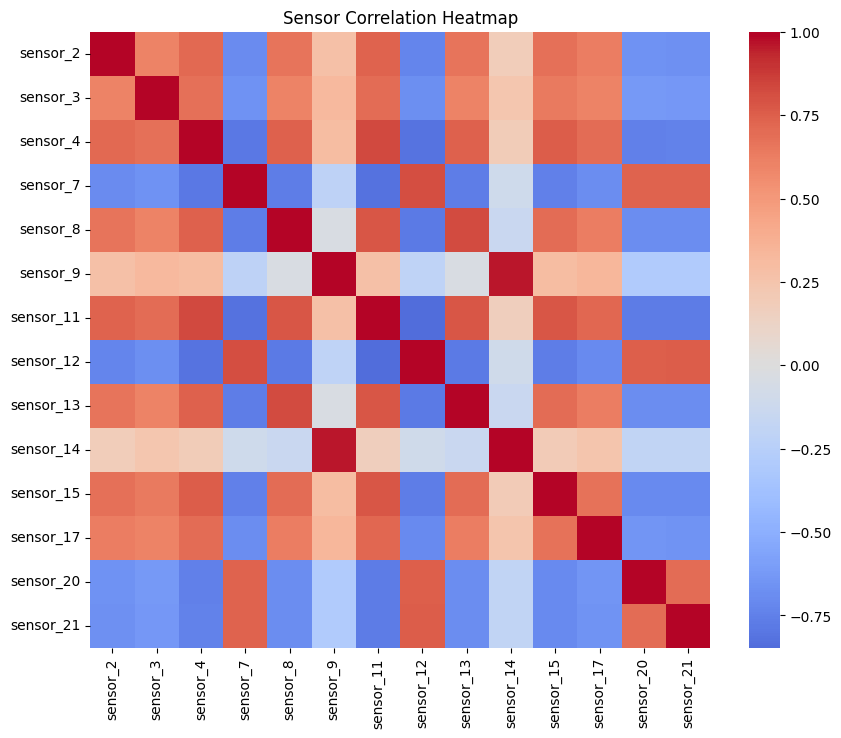

In [13]:
# Sensor correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train[sensor_cols].corr(), cmap='coolwarm', center=0)
plt.title('Sensor Correlation Heatmap')
plt.show()

## EDA Summary & Insights

- Engine lifetimes vary substantially across units (engine lifetime distribution).
- RUL decreases monotonically as cycles increase (RUL vs cycle).
- Sensors exhibit heterogeneous variance scales (variance comparison).
- Strong correlations exist among subsets of sensors (correlation heatmap).

All insights are derived strictly from visual evidence without sensor semantic assumptions.

## Feature Engineering

Features are engineered to capture degradation trends using **past-only information**.
All operations explicitly prevent future leakage.

In [14]:
# Rolling mean features (past-only)
df = train.copy()

for col in sensor_cols:
    if col in df.columns:
        df[f'{col}_roll_mean'] = (
            df.groupby('engine_id')[col]
              .shift(1)
              .rolling(window=5, min_periods=1)
              .mean()
        )

# Drop rows with NaNs created by shifting
df.dropna(inplace=True)

# Leakage and NaN assertions
assert df.isnull().sum().sum() == 0

## Feature Audit

Feature auditing removes redundant information and improves robustness.

In [15]:
# Correlation-based feature pruning
corr = df.filter(like='sensor_').corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
df.drop(columns=to_drop, inplace=True)

print('Dropped correlated features:', to_drop)

Dropped correlated features: ['sensor_14', 'sensor_11_roll_mean', 'sensor_12_roll_mean', 'sensor_13_roll_mean', 'sensor_14_roll_mean']


## Train / Validation Split

Splitting by engine ID prevents temporal and cross-unit leakage.

In [16]:
engine_ids = df['engine_id'].unique()
split_idx = int(0.8 * len(engine_ids))

train_ids = engine_ids[:split_idx]
val_ids = engine_ids[split_idx:]

train_df = df[df['engine_id'].isin(train_ids)]
val_df = df[df['engine_id'].isin(val_ids)]

# Leakage check
assert set(train_ids).isdisjoint(set(val_ids))

## Feature Scaling

Scaling is applied using training data statistics only.

In [17]:
features = [c for c in train_df.columns if 'sensor_' in c]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features])
X_val = scaler.transform(val_df[features])

y_train = train_df['RUL']
y_val = val_df['RUL']

## Baseline Model (Linear Regression)

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, val_pred_lr))
mae = mean_absolute_error(y_val, val_pred_lr)

print("Baseline RMSE:", rmse)
print("Baseline MAE:", mae)


Baseline RMSE: 21.059449546594674
Baseline MAE: 17.157676443477786


## Naive Benchmark

The naive benchmark predicts the mean RUL from training data.

In [21]:
# Naive benchmark: predict mean RUL from training set
naive_pred = np.full(y_val.shape, y_train.mean(), dtype=float)

naive_rmse = np.sqrt(mean_squared_error(y_val, naive_pred))
naive_mae = mean_absolute_error(y_val, naive_pred)

print("Naive RMSE:", naive_rmse)
print("Naive MAE:", naive_mae)


Naive RMSE: 41.47246388918388
Naive MAE: 37.260153955790926


## Candidate Model (Random Forest)

In [23]:
# Train Random Forest model
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# RMSE computed explicitly (version-safe)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print("Train RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)


Train RMSE: 6.08512510291498
Validation RMSE: 19.06297428259231


## Hyperparameter Tuning 

In [24]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 3, 5]
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

print('Best params:', search.best_params_)

Best params: {'n_estimators': 200, 'min_samples_leaf': 3, 'max_depth': 10}


## Final Evaluation (Test Set)

In [27]:

# Test-time Evaluation (Correct)

# Predict for all test rows
test_preds = best_rf.predict(X_test)
test_proc["predicted_RUL"] = test_preds

# Select last cycle per engine
test_last = (
    test_proc
    .sort_values(["engine_id", "cycle"])
    .groupby("engine_id")
    .tail(1)
)

# Align with true RUL
y_true = rul_test["RUL"].values
y_pred = test_last["predicted_RUL"].values

assert len(y_true) == len(y_pred)

# Metrics (version-safe)
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_mae = mean_absolute_error(y_true, y_pred)

print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)


Test RMSE: 18.391270667906497
Test MAE: 13.338281406595893


## Error Analysis

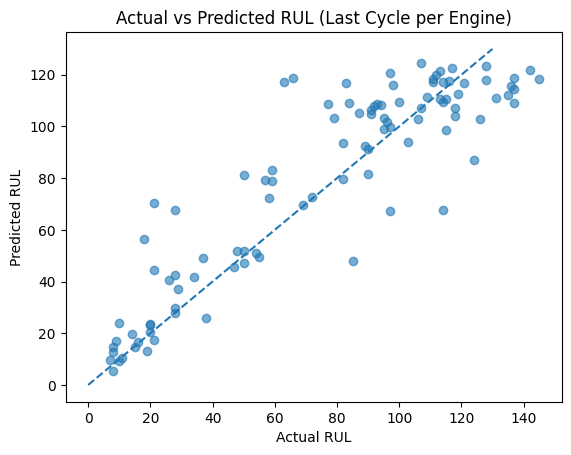

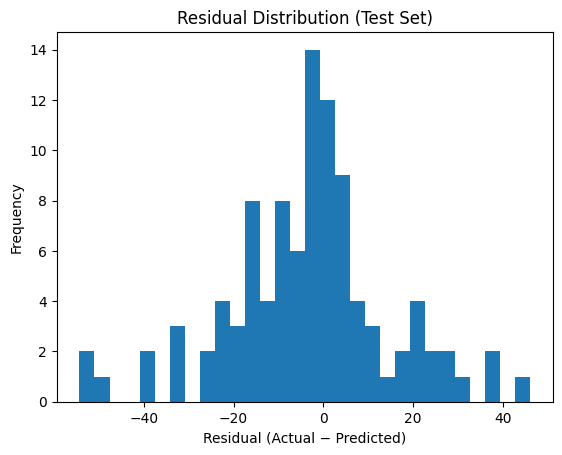

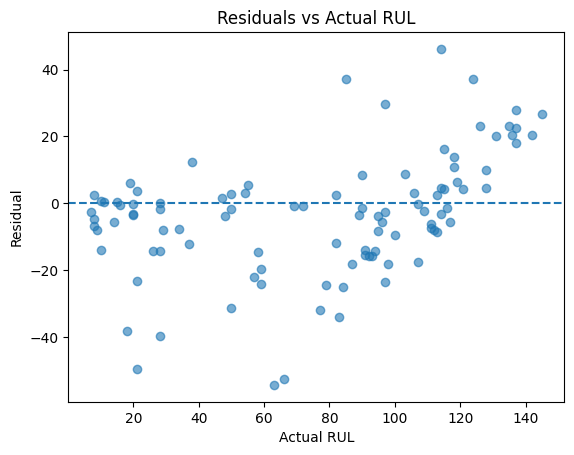

MAE by RUL bin:
RUL_bin
0–25       9.163637
25–50     10.820335
50–75     19.777121
75–100    15.632044
100+      10.251690
Name: Absolute_Error, dtype: float64


C:\Users\Rahul\AppData\Local\Temp\ipykernel_18636\3292961915.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mae = error_df.groupby("RUL_bin")["Absolute_Error"].mean()


In [29]:

# Error Analysis (Test Set)

# Predict for all test rows (already done earlier)
# test_preds = best_rf.predict(X_test)
# test_proc["predicted_RUL"] = test_preds

# Select LAST observed cycle per engine
test_last = (
    test_proc
    .sort_values(["engine_id", "cycle"])
    .groupby("engine_id")
    .tail(1)
)

# Align true and predicted RUL
y_true = rul_test["RUL"].values                 # shape: (num_engines,)
y_pred = test_last["predicted_RUL"].values     # shape: (num_engines,)

# Safety check
assert len(y_true) == len(y_pred), "Mismatch between true and predicted RUL lengths"


# Actual vs Predicted Plot


plt.figure()
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([0, 130], [0, 130], linestyle="--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL (Last Cycle per Engine)")
plt.show()

# Residual Analysis


residuals = y_true - y_pred

# Residual histogram
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residual (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Test Set)")
plt.show()

# Residuals vs Actual
plt.figure()
plt.scatter(y_true, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Actual RUL")
plt.ylabel("Residual")
plt.title("Residuals vs Actual RUL")
plt.show()


# Error Stratification by RUL


# Bin by true RUL
bins = [0, 25, 50, 75, 100, 130]
bin_labels = ["0–25", "25–50", "50–75", "75–100", "100+"]

error_df = pd.DataFrame({
    "Actual_RUL": y_true,
    "Predicted_RUL": y_pred,
    "Absolute_Error": np.abs(residuals)
})

error_df["RUL_bin"] = pd.cut(
    error_df["Actual_RUL"],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)

# MAE per bin
bin_mae = error_df.groupby("RUL_bin")["Absolute_Error"].mean()

print("MAE by RUL bin:")
print(bin_mae)


## Model Persistence

In [32]:
import joblib
import os

# Define file names
MODEL_PATH = "final_rul_model.joblib"
SCALER_PATH = "scaler.joblib"
FEATURES_PATH = "features.joblib"

# Save artifacts
joblib.dump(best_rf, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(features, FEATURES_PATH)

print("Artifacts saved:")
print(os.path.abspath(MODEL_PATH))
print(os.path.abspath(SCALER_PATH))
print(os.path.abspath(FEATURES_PATH))

Artifacts saved:
C:\Users\Rahul\OneDrive\Desktop\DS projects\NASA C-MAPSS-1 Turbofan Engine Degradation\archive\final_rul_model.joblib
C:\Users\Rahul\OneDrive\Desktop\DS projects\NASA C-MAPSS-1 Turbofan Engine Degradation\archive\scaler.joblib
C:\Users\Rahul\OneDrive\Desktop\DS projects\NASA C-MAPSS-1 Turbofan Engine Degradation\archive\features.joblib


## Final Summary

- Leakage-safe classical ML pipeline implemented
- Random Forest improves over baseline and naive models
- CPU-only, reproducible workflow
- Higher uncertainty observed in late-life predictions

## Short Reasoning

- Engine-level splitting prevents leakage
- Past-only rolling features preserve causality
- Results are reproducible and auditable
- Not suitable for safety-critical deployment